### Regresion Lineal

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

from pandas_profiling import ProfileReport

from pathlib import Path
current_dir = Path(".").resolve()
project_dir = current_dir.parent

print(current_dir)
print(project_dir)

/home/jupyter/ESEIT_BigData/notebooks
/home/jupyter/ESEIT_BigData


In [2]:
#reinicio de Kernel
%load_ext autoreload 
#Reinicio en carpetas para tomar nuevos cambios
%autoreload 2 

In [3]:
file_data = os.path.join(project_dir,"data", "Housing.csv")
data = pd.read_csv(file_data)

data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Exploratory Data Analysis (EDA)

In [4]:
report = ProfileReport(df=data, minimal=True)
report

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
target = 'price'

num_cols = ['area']
ord_cols = ['bedrooms', 'bathrooms', 'stories']
cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
             'parking', 'prefarea', 'furnishingstatus']

<AxesSubplot:xlabel='area', ylabel='price'>

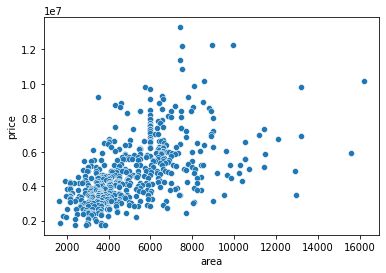

In [6]:
sns.scatterplot(x='area', y='price', data=data)

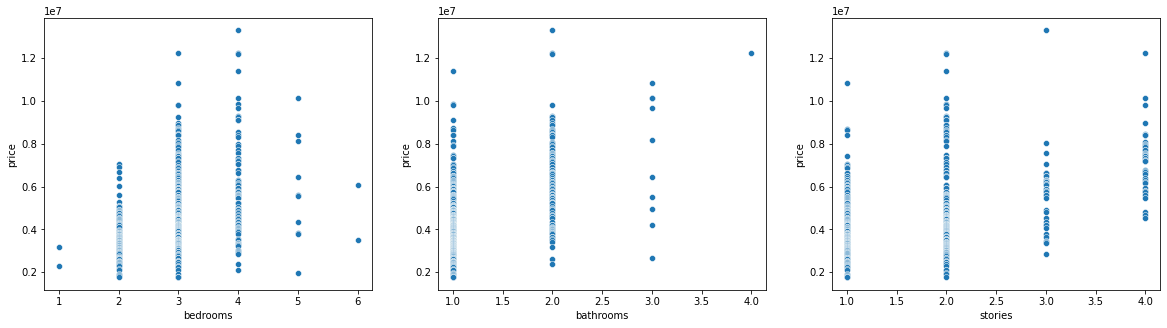

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 5) )
axes = axes.flatten()

for i, col in enumerate(ord_cols):
    sns.scatterplot(x=col, y='price', data=data, ax=axes[i])

IndexError: index 6 is out of bounds for axis 0 with size 6

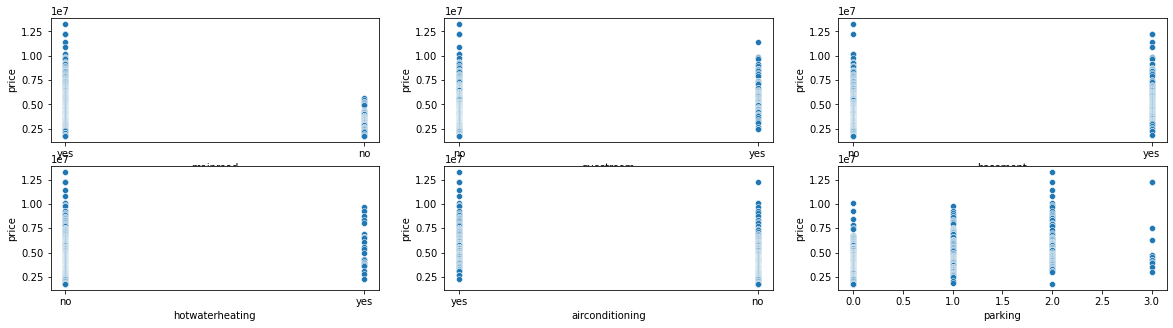

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 5) )
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.scatterplot(x=col, y='price', data=data, ax=axes[i])

## Feature Engineering

* Converting Numeric cols to categorical cols
* New variables
* One-hot encoder

In [ ]:
data['area'].quantile([0.20, 0.4, 0.6, 0.8])

In [ ]:
data["area_cat"] = pd.cut(data["area"],
                          bins =[0., 3450, 4065, 5400, 6600, np.inf],
                          labels=[1, 2, 3, 4, 5])

data['area_cat'].value_counts()

In [ ]:
sns.scatterplot(x='area_cat', y='price', data=data)

In [ ]:
corr_matrix = data.corr()
corr_matrix["price"].sort_values(ascending=False)

In [ ]:
data["lux_home"] = data["bathrooms"] + data["bedrooms"] + data["parking"]
corr_matrix = data.corr()
corr_matrix["price"].sort_values(ascending=False)

In [ ]:
data

In [ ]:
data["lux_home"].hist()

## One-Hot Encoder

In [ ]:
data_dummies = pd.get_dummies(data[cat_cols])
data_dummies.head()

In [ ]:
data_ord = data[ord_cols]
data_ord.head()

In [ ]:
list_df = [
    data[['price']],
    data_dummies,
    data_ord,
]

data_fe = pd.concat(list_df, axis=1)
data_fe.shape

In [ ]:
data_fe

In [ ]:
corr_matrix = data_fe.corr()
corr_matrix["price"].sort_values(ascending=False)

## Train Model 

In [ ]:
from sklearn.model_selection import train_test_split

cols = data_fe.columns
X = data_fe[[col for col in cols if col != 'price']]
y = data['price']/1.0e6

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

In [ ]:
y_pred_lr    = lr.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

## Errores Residuales

In [ ]:
plt.scatter(y_pred_lr ,    y_test-y_pred_lr,    color='orange', label='Lin. Reg')
plt.scatter(y_pred_ridge , y_test-y_pred_ridge, color='blue',   label='Ridge. Reg')
plt.scatter(y_pred_lasso , y_test-y_pred_lasso, color='red',    label='Lasso. Reg')

plt.legend()

plt.ylabel('Residuals')
plt.xlabel('Predictions')

In [ ]:
plt.hist(y_test-y_pred_lr,    bins=30, color='orange', label='Lin. Reg',   alpha=0.3)
plt.hist(y_test-y_pred_ridge, bins=30, color='blue',   label='Ridge. Reg', alpha=0.3)
plt.hist(y_test-y_pred_lasso, bins=30, color='red',    label='Lasso. Reg', alpha=0.3)

plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Frequency')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

print('Model', 'MSE', 'R2')
print('Lineal. Reg', mean_squared_error(y_test, y_pred_lr), r2_score(y_test, y_pred_lr))
print('Ridge.  Reg', mean_squared_error(y_test, y_pred_ridge), r2_score(y_test, y_pred_ridge) )
print('Lasso.  Reg', mean_squared_error(y_test, y_pred_lasso), r2_score(y_test, y_pred_lasso) )

In [ ]:
# QQ plot

plt.scatter(np.sort(y_pred_lr), np.sort(y_test))
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red')

### Mejora de puntajes en Regresión Lineal

In [9]:
!pip install --upgrade tensorflow

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import logging
import sys
from datetime import timedelta
import matplotlib.pyplot as plt
from dateutil.parser import parse
from pandas_profiling import ProfileReport
import seaborn as sns

from pathlib import Path

current_dir = Path(".").resolve()
project_dir = current_dir.parent

2022-06-11 13:02:46.888875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-11 13:02:46.888933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
tf.__version__

'2.9.1'

In [12]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['mainroad_code']       = le.fit_transform(data['mainroad'])
data['guestroom_code']       = le.fit_transform(data['guestroom'])
data['basement_code']       = le.fit_transform(data['basement'])
data['hotwaterheating_code']       = le.fit_transform(data['hotwaterheating'])
data['airconfitioning_code']       = le.fit_transform(data['airconditioning'])
data['prefarea_code']       = le.fit_transform(data['prefarea'])
data['furnishingstatus_code']       = le.fit_transform(data['furnishingstatus'])


data['log_price']    = np.log(data['price'] + 0.1)
data['log_area']    = np.log(data['area'] + 0.1)
data['log_bedrooms']    = np.log(data['bedrooms'] + 0.1)
data['log_stories']    = np.log(data['stories'] + 0.1)
data['log_parking']    = np.log(data['parking'] + 0.1)

In [16]:
##data=data.drop(['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus',
  ##               'price','area','bedrooms','stories','parking'  ],axis=1)
data.head()

,bathrooms,mainroad_code,guestroom_code,basement_code,hotwaterheating_code,airconfitioning_code,prefarea_code,furnishingstatus_code,log_price,log_area,log_bedrooms,log_stories,log_parking
0,2,1,0,0,0,1,1,0,16.403275,8.911948,1.410987,1.131402,0.741937
1,4,1,0,0,0,1,0,0,16.321037,9.100537,1.410987,1.410987,1.131402
2,2,1,0,1,0,0,1,1,16.321037,9.206342,1.131402,0.741937,0.741937
3,2,1,0,1,0,1,1,0,16.318175,8.922672,1.410987,0.741937,1.131402
4,1,1,1,1,0,1,0,0,16.250001,8.911948,1.410987,0.741937,0.741937


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

In [20]:
X = data.drop(columns='log_price')
y = data['log_price']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

#### Elastic Net

In [21]:
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.77911854513457, tolerance: 0.004955849543132861
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coor

In [22]:
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
102,0.00,0.000217,0.043534,0.208648
103,0.00,0.000187,0.043534,0.208648
104,0.00,0.000161,0.043538,0.208659
101,0.00,0.000252,0.043540,0.208663
105,0.00,0.000138,0.043545,0.208676
...,...,...,...,...
464,0.50,0.065932,0.140645,0.375027
463,0.50,0.076634,0.140645,0.375027
462,0.50,0.089074,0.140645,0.375027
874,0.90,0.014650,0.140645,0.375027


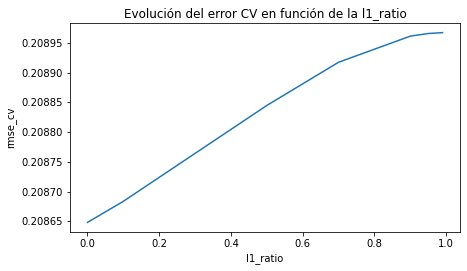

In [23]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [24]:
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 0.00021711179456945052
Mejor valor de l1_ratio encontrado: 0.0


In [25]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

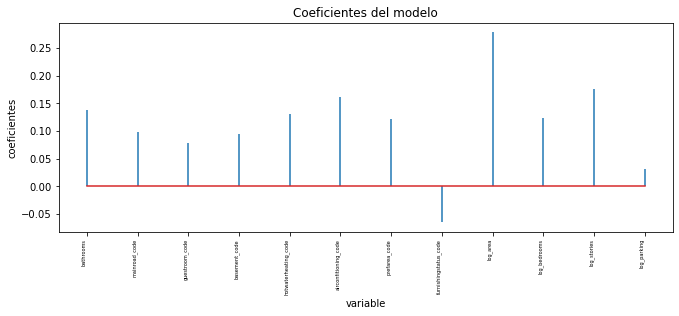

In [26]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [27]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
# Error de test del modelo 
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 0.21001600073304005
